# Model Learning: $L^*$

Let us fix some unknown regular language $L$ that we want to learn. Your objectives will be to:

  1. implement an observation table;
  2. implement $L^*$;
  3. measure the number of queries that are used to learn an automaton;
  4. test different approaches to process a counterexample; and
  5. apply $L^*$ to discover a bug in an implementation.

Throughout this notebook, the functions and parts you have to work on are tagged with FIXME. You are allowed to define new functions and class fields.

You need to install the AALpy Python library (`pip install aalpy`), and [GraphViz](https://graphviz.org/) (`sudo apt install graphviz` on Debian-based distributions).

Two new types are defined:
  - `Symbol` (which is equivalent to `str`); and
  - `Word` (which is a list of `Symbol`).
The functions defined in the cells of this notebook use these types for clarity. Moreover, the global variable `empty_word` is defined (as the empty list). Finally, the following functions are available:
  - `concat(w1: Word, w2: Word) -> Word`, which takes two words $w_1$ and $w_2$ and returns the word $w_1 \cdot w_2$;
  - `append_symbol(w: Word, s: Symbol) -> Word`, which takes a word $w$ and a symbol $s$ and returns $w \cdot s$;
  - `prepend_symbol(s: Symbol, w: Word) -> Word`, which takes a word $w$ and a symbol $s$ and returns $s \cdot w$;
  - `prefixes(w: Word) -> List[Word]`, which returns the list of all the prefixes of $w$; and
  - `suffixes(w: Word) -> List[Word]`, which returns the list of all the suffixes of $w$.

In [2]:
import aalpy
from aalpy import SUL, Oracle, Dfa, DfaState
from statistics import fmean
import matplotlib.pyplot as plt
import tests
import itertools
import copy
import random
from typing import *
from utils import *

## 0 - Relevant AALpy methods

Throughout these exercises, you will manipulate instances of two AALpy classes:
  - `SUL` implements a membership oracle:
    - `sul.query(word: Word)`, returns a list of Booleans, where the $i$-th Boolean is true if the automaton accepts the prefix of length $i$ of `word`. Formally, if `word` is the sequence of input symbols $i_1 i_2 \dotsb i_n$, the function returns a list $[o_1, o_2, \dotsc, o_n]$ such that, for every $j$, $o_j$ is true if and only if $i_1 \dotsb i_j \in L$.
  - `Oracle` implements an equivalence oracle:
    - `oracle.find_cex(hypothesis: DFA)`, returns a word that is a counterexample, or None.

## 1 - Observation table

The first exercise focuses on implementing an observation table.

### Recap

An *observation table* is a tuple $\mathcal{O} = (R, S, T)$ where:

  - $R$ is a non-empty, finite, prefix-closed of *representatives*.
  - $S$ is a non-empty, finite, suffix-closed of *separators*.
  - $T : (R \cup R \cdot \Sigma) \cdot S \to \mathbb{B}$ records whether the word $r \cdot s$ (with $r \in R \cup R \cdot \Sigma$ and $s \in S$) belong to $L$.

An observation table $\mathcal{O}$ induces an equivalence relation $\equiv{} \subseteq (R \cup R \cdot \Sigma) \times (R \cup R \cdot \Sigma)$: for every $r, r' \in R$, we have $r \equiv r'$ if and only if, for every $s \in S$, $T(r \cdot s) = T(r' \cdot s)$.

An observation table is said *closed* if, for every $r \in R \cdot \Sigma$, there exists some $r' \in R$ such that $r \equiv r'$.

An observation table is said *consistent* if, for every $a \in \Sigma$ and $r, r' \in R$ such that $r \equiv r'$, it holds that $r \cdot a \equiv r' \cdot a$.

Once the table is closed and consistent, it is possible to construct a hypothesis DFA from the equivalence classes of $\equiv$.

### Tasks

Two classes are provided:

  - `Row`, which stores:
    - the word labelling the row (i.e., the word in $R \cup R \cdot \Sigma$),
    - whether the word belongs to $R$ or $R \cdot \Sigma$, and
    - the content of the row, as a list of Booleans.
  - `ObservationTable` which implements an observation table. The following fields are defined:
    - `sul` is the membership oracle,
    - `alphabet` is the input alphabet,
    - `rows` is a list of instances of `Row`, and
    - `separators` is a list of separators, i.e., $S$.

`ObservationTable` also declares methods. Some are them are already implemented. You are tasked with implementing the following functions:

  1. `get_representatives()` that returns $R$.
  2. `get_row(word: Word)` that returns the row for the given word. If the row is not present, the function returns None.
  3. `add_row(word: Word, representative: bool)` that adds a new row (i.e., a row for a new element of $R \cup R \cdot \Sigma$) inside the table. This function must fill $T$.
  4. `add_representative(word: Word)` that adds a new element in $R$ and its corresponding row. Note that the word may already exist in $R \cdot \Sigma$. You can assume that the prefixes of the word are already in $R$. This function must fill the missing values in $T$.
  5. `add_separator(word: Word)` that adds a new element in $S$. You can assume that the suffixes of the word are already in $S$. This function must fill the missing values in $T$.
  6. `find_unclosed()` that returns a row in the lower part of the table that has no equivalent row in the upper part of the table, or None.
  7. `make_closed(row: Row)` that fixes the unclosedness of `row`.
  8. `find_inconsistency()` that returns a tuple with two rows whose words are $w_1$ and $w_2$, and a symbol $a$ such that $w_1 \cdot a \not\equiv w_2 \cdot a$.
  9. `make_consistent(row1: Row, row2: Row, symbol: Symbol)` that fixes the inconsistency.
  10. `make_closed_and_consistent()` that ensures that the table is closed and consistent.
  11. `process_counterexample(word: Word)` that treats a counterexample by adding each prefix of word as a new representative.

Unit tests are automatically executed at the end of the cell.

In [6]:
class Row:
    def __init__(self, word: Word, representative: bool, content: List[bool]):
        self.word = word
        self.representative = representative
        self.content = content

    def equivalent(self, row: "Row") -> bool:
        return self.content == row.content


class ObservationTable:
    def __init__(self, sul: SUL, alphabet: List[Symbol]):
        self.sul: SUL = sul
        self.alphabet: List[Symbol] = alphabet
        self.rows: List[Row] = []
        self.separators: List[Word] = []
        self.add_representative(empty_word)
        self.add_separator(empty_word)
        print(self.sul.query(empty_word))

    def number_rows(self) -> int:
        return len(self.rows)

    def number_separators(self) -> int:
        return len(self.separators)

    def construct_hypothesis(self) -> Dfa:
        selected_rows = []
        for row in filter(lambda r: r.representative, self.rows):
            if all(row.content != r.content for r in selected_rows):
                selected_rows.append(row)
        empty_row = self.get_row(empty_word)
        for i, selected in enumerate(selected_rows):
            if empty_row.equivalent(selected):
                initial_index = i

        states = [
            DfaState(f"s{i}", selected_rows[i].content[0])
            for i in range(len(selected_rows))
        ]
        for i, selected in enumerate(selected_rows):
            for symbol in self.alphabet:
                target_row = self.get_row(append_symbol(selected.word, symbol))
                for j, sel in enumerate(selected_rows):
                    if sel.equivalent(target_row):
                        states[i].transitions[symbol] = states[j]
        return Dfa(states[initial_index], states)

    def get_representatives(self) -> List[Word]:
        return [row.word for row in self.rows if row.representative]

    def get_row(self, word: Word) -> Row:
        for row in filter(lambda r: r.word == word, self.rows):
            return row
        return None

    def add_row(self, word: Word, representative: bool) -> None:
        if not self.get_row(word) is None:
            return
        content = []
        for seperator in self.separators:
            accept = self.sul.query(word + seperator).pop()
            content.append(accept)
        self.rows.append(Row(word, representative, content))

    def add_representative(self, representative: Word) -> None:
        row = self.get_row(representative)
        if row == None:
            self.add_row(representative, True)
        elif not row.representative:
            row.representative = True

        for symbol in self.alphabet:
            self.add_row(append_symbol(representative, symbol), False)

    def add_separator(self, separator: Word) -> None:
        if separator in self.separators:
            return
        self.separators.append(separator)
        for row in self.rows:#type Row
            accept = self.sul.query(row.word + separator).pop()
            row.content.append(accept)
        pass

    def find_unclosed(self) -> Row or None:
        for row in filter(lambda r: not r.representative, self.rows):
            found = False
            for row1 in filter(lambda r: r.representative, self.rows):
                if row.content == row1.content:
                    found = True
            if not found:
                return row
        return None

    def make_closed(self, row: Row) -> None:
        self.add_representative(row.word)

    def find_inconsistency(self) -> Tuple[Row, Row, Symbol]:
        # Get the represent
        representives1 = self.get_representatives()
        representives2 = self.get_representatives()
        for word1 in representives1:#type: Word
            for word2 in representives2:#type: Word
                # Check if the two words are equivalent but not the same
                if self.get_row(word1).equivalent(self.get_row(word2)) and word1 != word2:
                    # For each symbol in the alphabet, check if appending it to both words leads to an inconsistency
                    for symbol in self.alphabet:
                        # Append the symbol to both words and get the new rows
                        new_row1 = self.get_row(append_symbol(word1, symbol))
                        new_row2 = self.get_row(append_symbol(word2, symbol))
                        # If either row is None, it means the word was not found
                        if new_row1 is None or new_row2 is None:
                            # print("Row not found for", append_symbol(word1, symbol), "or", append_symbol(word2, symbol), flush=True)
                            continue
                        # If the new rows are not equivalent, we found an inconsistency
                        if not new_row1.equivalent(new_row2):
                            # print("INCONSISTENCY FOUND", flush=True)
                            return new_row1, new_row2, symbol
        return None

    def make_consistent(self, row1: Row, row2: Row, symbol: Symbol) -> None:
        # print("MAKE CONSISTENT", flush=True)
        # print("ADD SYMBOL" + symbol, flush=True)
        # Check if the content of the rows differ
        for i in range(len(row1.content)):
            # If they differ, add a separator and return
            if row1.content[i] != row2.content[i]:
                # print("ADD SEPARATOR", flush=True)
                # Append the symbol to the separator and add it
                addVal = prepend_symbol(symbol, self.separators[i])
                self.add_separator(addVal)
                return


    def make_closed_and_consistent(self) -> None:
        # print("MAKE CLOSED", flush=True)
        while True:
            unclosed = self.find_unclosed()
            if unclosed:
                self.make_closed(unclosed)
                continue

            inconsistency = self.find_inconsistency()
            if inconsistency:
                self.make_consistent(*inconsistency)
                continue

            break


    def process_counterexample(self, word: Word) -> None:
        for prefix in prefixes(word):
            self.add_representative(prefix)

tests.run_tests_observation_table(ObservationTable)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.008s

OK


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


## 2 - $L^*$

Implement $L^*$, using `ObservationTable`. The `lstar` function takes the following parameter:
  - `sul: SUL`, the membership oracle;
  - `alphabet: List[Symbol]`, the alphabet;
  - `eq_oracle: Oracle`, the equivalence oracle; and
  - `tableType`, the type of the observation table. This will permit us to use a different implementation in Section 4.

Unit tests are automatically executed at the end of the cell.

In [16]:
def lstar(sul: SUL, alphabet: List[Symbol], eq_oracle: Oracle, tableType) -> Dfa:
    table = tableType(sul, alphabet)
    counter = 0
    while True:
        # print("MAKE CONSISTENT AND CLOSED", flush=True)
        table.make_closed_and_consistent()
        # print("Seperators: " + str(table.separators), flush=True)
        # print("Representatives: " + ", ".join(map(str, table.get_representatives())), flush=True)
        # print("Rows: " + str(table.number_rows()), flush=True)
        # print("CONSTRUCT HYPOTHESIS", flush=True)
        hypothesis = table.construct_hypothesis()
        w = eq_oracle.find_cex(hypothesis)
        if w is None:
            print("DONE", flush=True)
            return hypothesis

        # print(w)
        # print("PROCESS CE", flush=True)
        table.process_counterexample(w)
        # counter += 1
        # if counter == 100:
        #     return hypothesis

tests.run_tests_lstar(ObservationTable, lstar)

[False]
DONE
[False]
DONE


.

[False]
DONE


.
----------------------------------------------------------------------
Ran 2 tests in 0.023s

OK


## 3 - Experimental evaluation

We now measure how many queries are used by $L^*$ to infer a correct DFA, as well as the size of the table.

### Tasks

  1. Implement `measure_lstar(tableType, states_range, alphabet_range, repetitions)` that runs $L^*$ on multiple instances and measure, on average, how many queries are performed per number of input symbols and number of states of the target automaton. The result must be a dictionary whose keys are the sizes of the alphabet, and whose values are dictionaries whose keys are the sizes of the target automata, and whose values are tuples with:
    - the average number of membership queries,
    - the average number of equivalence queries,
    - the average number of representatives (i.e., the size of $R$), and
    - the average number of separators (i.e., the size of $S$).
  2. Implement `plot(queries)` that create multiple figures: for each alphabet size, plot, per number of states, the numbers of membership queries, equivalence queries, representatives, and separators. The `queries` argument is the result of `measure_lstar`.

To help you implementing the functions, you can call `run_experiment(tableType, lstar, num_states, alphabet_size) -> Tuple[int, int, int, int]` which generates a random alphabet of the given size and a random DFA of the given size, and run the provided `lstar` method with `tableType`. This function returns a tuple with the number of membership queries, of equivalence queries, of representatives, and of separators.

[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DON

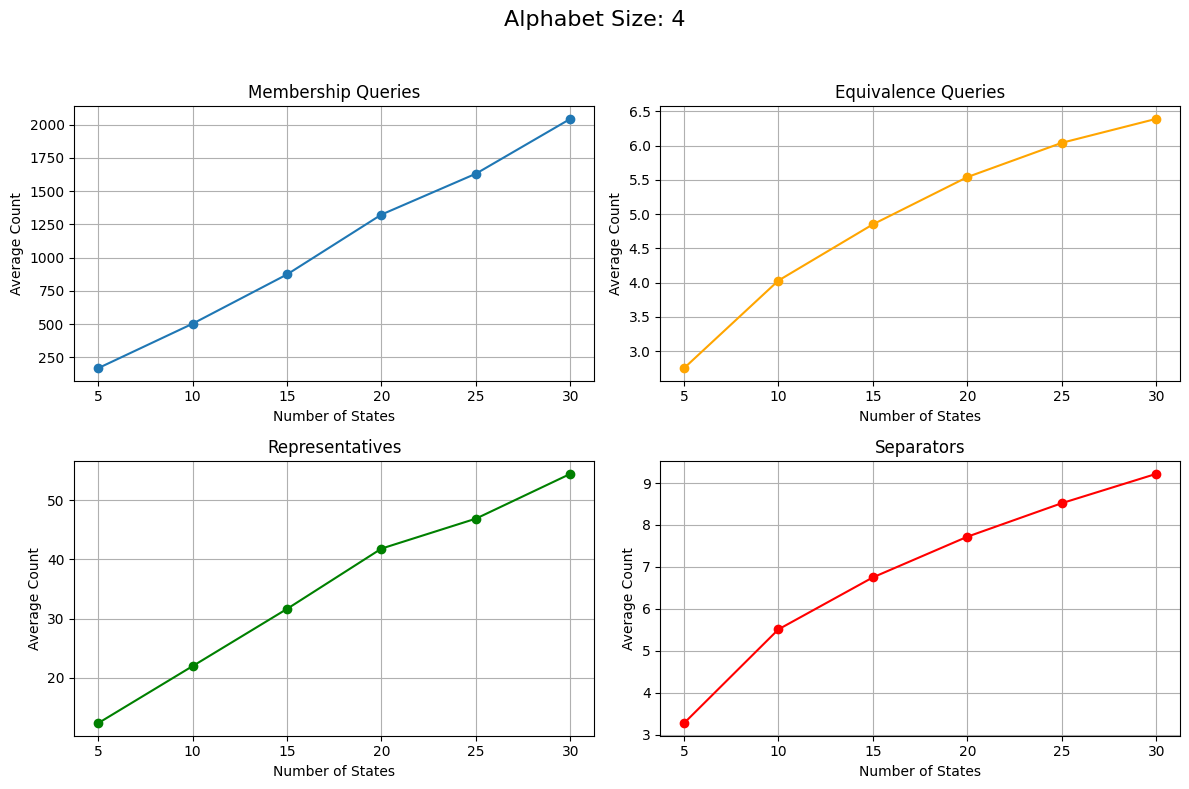

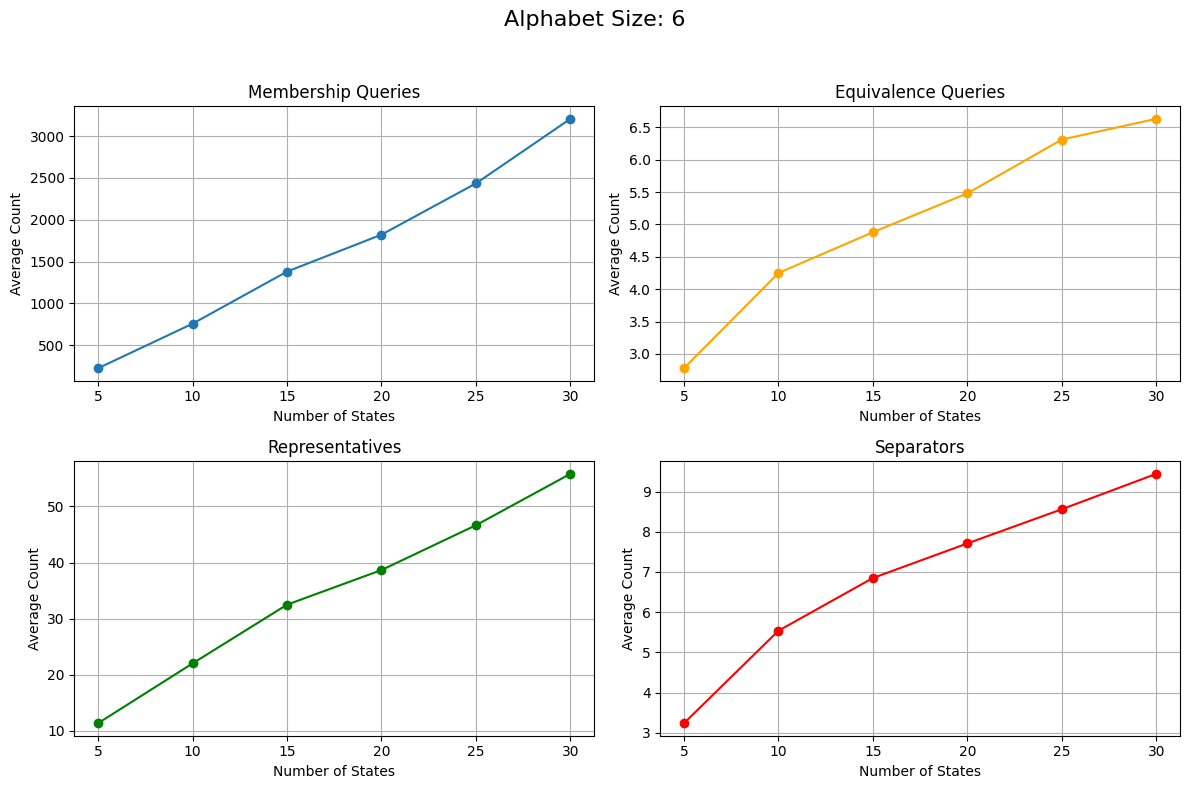

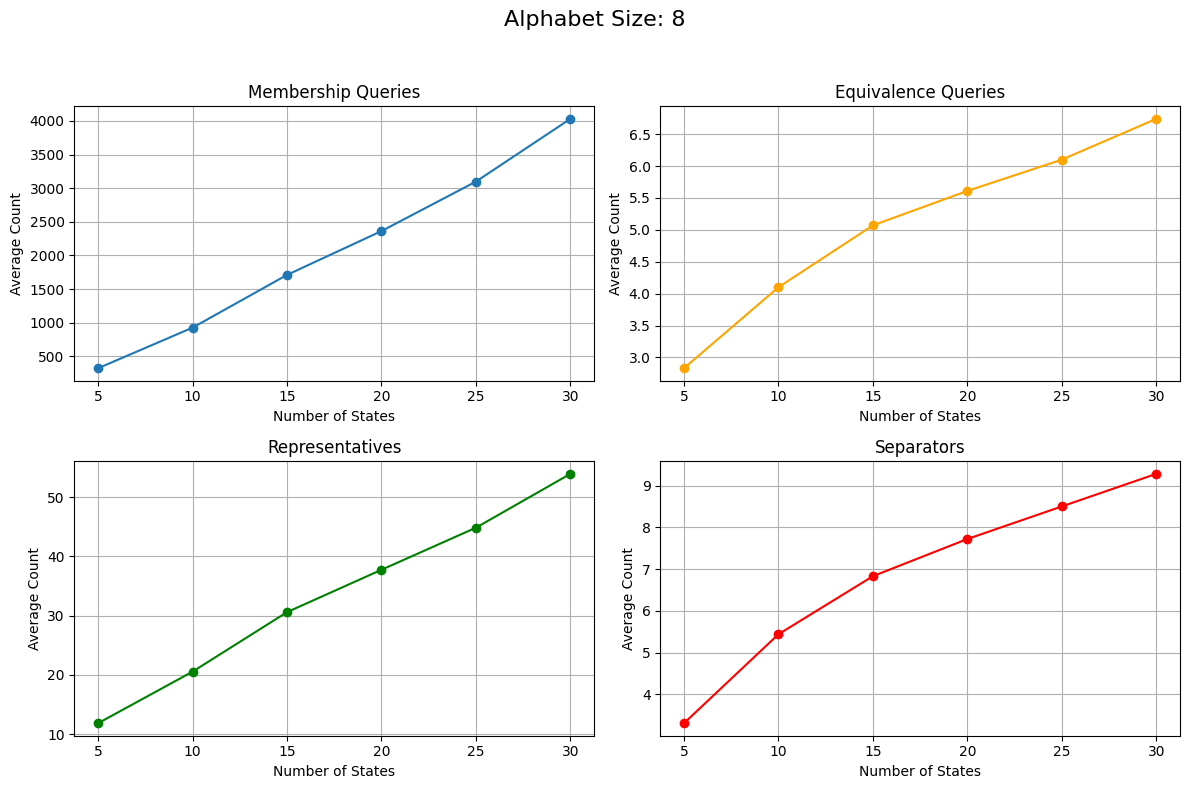

In [17]:
def measure_lstar(tableType, states_range: range, alphabet_range: range, repetitions: int) -> Dict[int, Dict[int, Tuple[float, float, float, float]]]:
    random.seed(35) # To generate the same random automata each run

    big_d = dict()
    for alphabet in alphabet_range:
        small_d = dict()
        for state in states_range:
            total_MQ = 0
            total_EQ = 0
            total_prep = 0
            total_sep = 0
            for i in range(repetitions):
                mq, eq, reps, seps = run_experiment(tableType, lstar, state, alphabet)
                total_MQ += mq
                total_EQ += eq
                total_prep += reps
                total_sep += seps
            small_d[state] = (total_MQ/repetitions, total_EQ/repetitions, total_prep/repetitions, total_sep/repetitions)
        big_d[alphabet] = small_d
    # print(big_d)
    return big_d


# def plot(queries: Dict[Tuple[int, int], Tuple[float, float]]) -> None:
#     n_rows = len(queries)
#     n_columns = 4
#     import matplotlib.pyplot as plt

def plot(queries: Dict[int, Dict[int, Tuple[float, float, float, float]]]) -> None:
    metrics = ["Membership Queries", "Equivalence Queries", "Representatives", "Separators"]
    for alphabet_size, data in queries.items():
        states = list(data.keys())
        mq, eq, reps, seps = zip(*data.values())

        plt.figure(figsize=(12, 8))
        plt.suptitle(f"Alphabet Size: {alphabet_size}", fontsize=16)

        # Membership Queries
        plt.subplot(2, 2, 1)
        plt.plot(states, mq, marker='o', label="MQ")
        plt.title(metrics[0])
        plt.xlabel("Number of States")
        plt.ylabel("Average Count")
        plt.grid(True)

        # Equivalence Queries
        plt.subplot(2, 2, 2)
        plt.plot(states, eq, marker='o', label="EQ", color="orange")
        plt.title(metrics[1])
        plt.xlabel("Number of States")
        plt.ylabel("Average Count")
        plt.grid(True)

        # Representatives
        plt.subplot(2, 2, 3)
        plt.plot(states, reps, marker='o', label="Representatives", color="green")
        plt.title(metrics[2])
        plt.xlabel("Number of States")
        plt.ylabel("Average Count")
        plt.grid(True)

        # Separators
        plt.subplot(2, 2, 4)
        plt.plot(states, seps, marker='o', label="Separators", color="red")
        plt.title(metrics[3])
        plt.xlabel("Number of States")
        plt.ylabel("Average Count")
        plt.grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


results = measure_lstar(ObservationTable, range(5, 31, 5), range(4, 9, 2), 100)
plot(results)

## 4 - Counterexample processing

Adding all the prefixes of the counterexample as new representatives in the observation table is not the only way to process a counterexample. Another possibility is to add all its suffixes as new separators. Let us explore this, and experimentally compare both approaches.

### Tasks

  1. Implement the following `process_counterexample(word: Word)` that adds the suffixes of the word as new separators.
  2. Compare the experimental results of adding the prefixes or the suffixes.

[False]
DONE
[False]
DONE


.

[False]
DONE


.
----------------------------------------------------------------------
Ran 2 tests in 0.011s

OK


[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[True]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[False]
DONE
[False]
DONE
[True]
DONE
[False]
DONE
[True]
DONE
[Fa

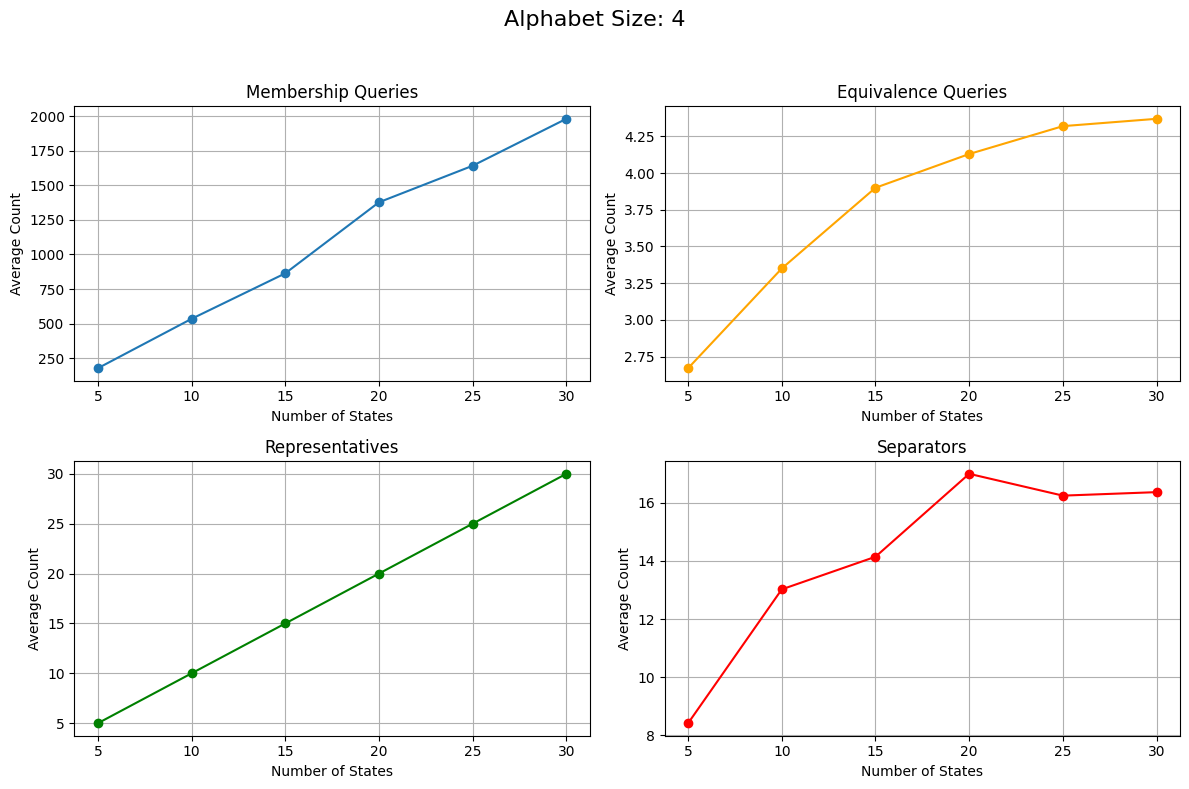

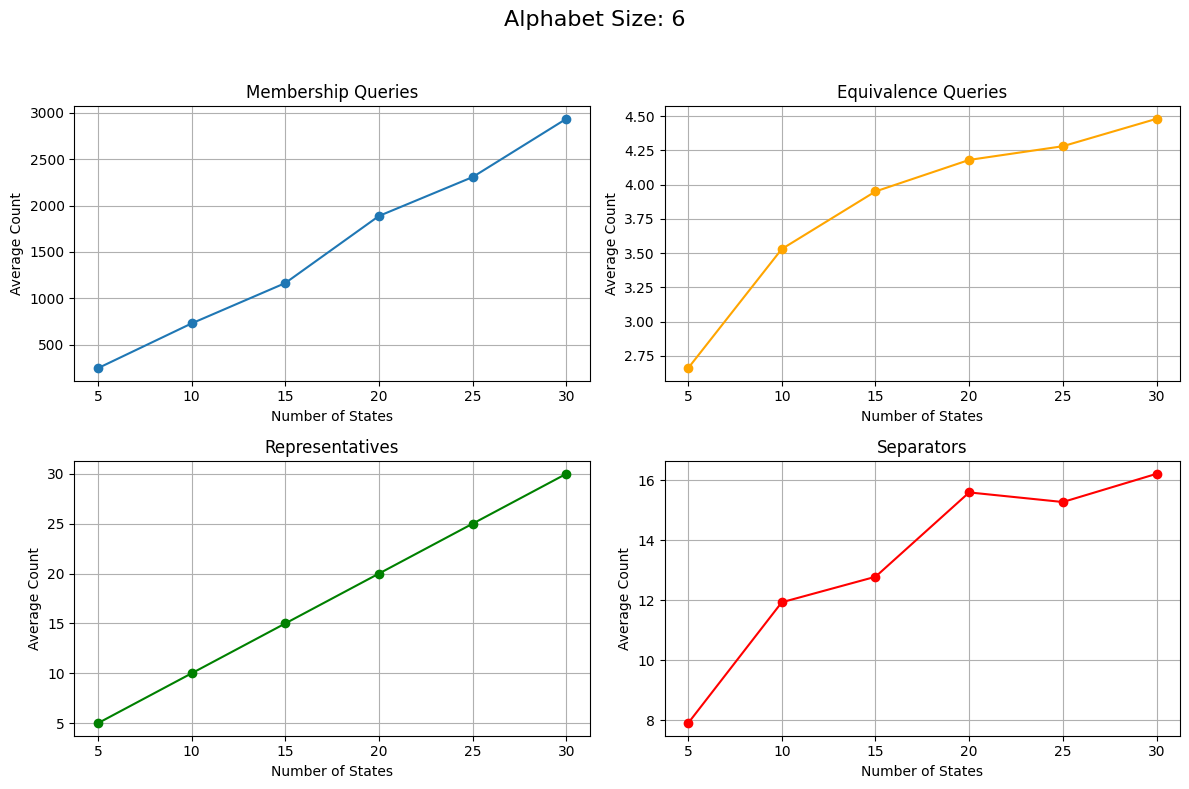

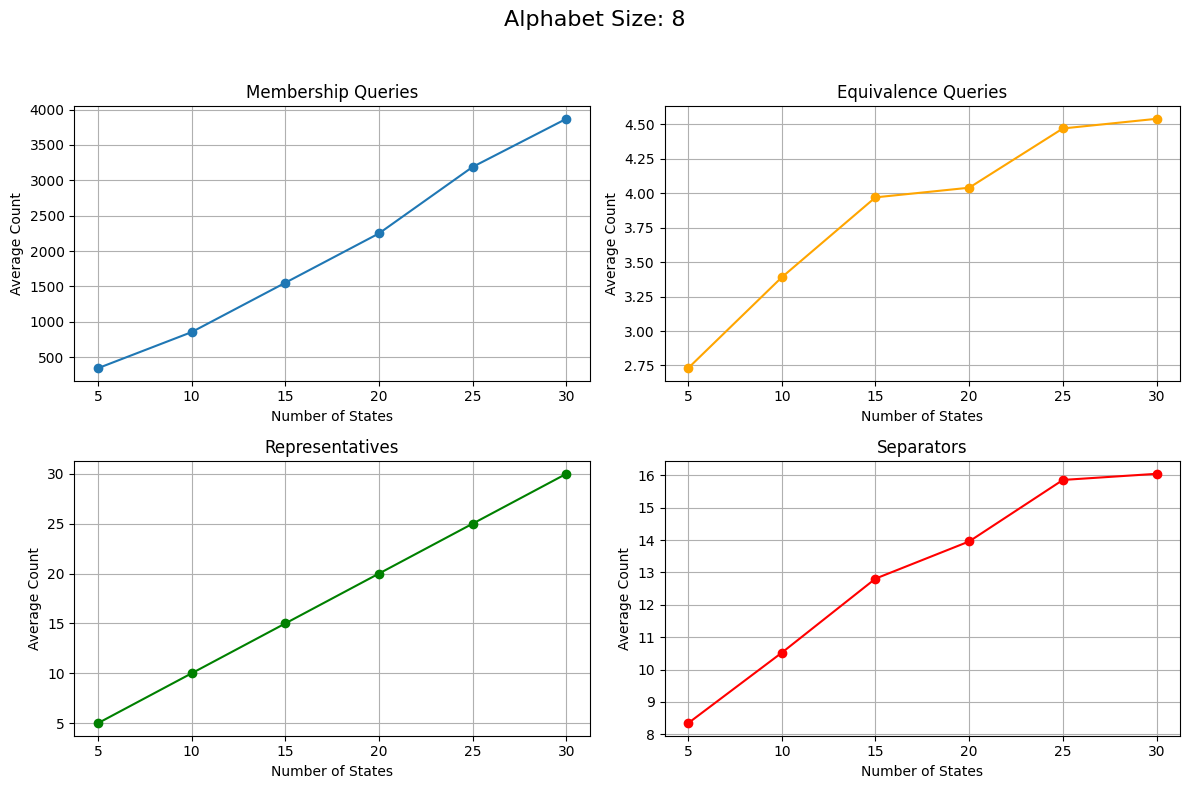

In [18]:
class ObservationTableSuffixes(ObservationTable):
    @override
    def process_counterexample(self, word: Word):
        suff = suffixes(word)
        
        for element in suff:
            if element != word:
                self.add_separator(element)

        #we moeten hier wss hetzelfde doen als in oef 1

        return

tests.run_tests_lstar(ObservationTableSuffixes, lstar)

results = measure_lstar(ObservationTableSuffixes, range(5, 31, 5), range(4, 9, 2), 100)
plot(results)

## 5 - Learning to model check

To conclude these exercises, we apply $L^*$ to infer a DFA $\mathcal{A}$ from an existing implementation. Once $\mathcal{A}$ is known, we can check whether the implementation behaves as expected.

In order to obtain $\mathcal{A}$, we will rely on *probably approximately correct* learning. That is, we can query the implementation for membership queries, but equivalence queries are approximated by testing random words. A SUL (i.e., a membership oracle) is already provided. You are tasked with implementing the equivalence oracle, and checking whether the resulting automaton behaves as expected.

Recall that the number of words to test is given by
$$r_i = \left\lceil \frac{1}{\varepsilon} \left(\ln \frac{1}{\delta} + (\ln 2) (i + 1)\right) \right\rceil,$$
where $i$ is the number of already testes hypotheses.

### Description of the system

We consider a printer secured by a keycard. Initially, it is powered off. When the machine is powered on, it boots in its locked status. In order to access the printer's functionalities, the user must swipe their keycard to unlock the printer.

Once the printer is unlocked, the user has two possibilities:
  - they can either swipe their keycard again to lock the system, or
  - print a document.
If the printer is unlocked but no action occurs within a given time window, it automatically locks itself.

When the printer is done printing a document, it returns in its unlocked status by default. The user may swipe their keycard to lock the system during printing (in which case, the printer will still finish its job).

At any point, the power may be cut off at any point, stopping the printer.

### Tasks

  1. Draw a DFA modeling the printer behavior, using $\Sigma = \{\mathrm{power}, \mathrm{keycard}, \mathrm{timeout}, \mathrm{print}, \mathrm{done}\}$.
  2. Fill the functions of `RandomWordsEQ`.
  3. Run $L^*$ with the given SUL and an instance of `RandomWordsEQ`.
  4. Is the automaton correct? (Hint: the `Dfa` class of AALpy implements a `visualize` method.)

In [19]:
import random
import math
from system import get_sul

class RandomWordsEQ(Oracle):
    def __init__(self, alphabet: List[Symbol], sul: SUL, accuracy: float, confidence: float):
        super().__init__(alphabet, sul)
        self.n_queries = 0
        self.accuracy = accuracy
        self.confidence = confidence
        # You also have access to self.sul and self.alphabet

    def _get_hypo_output(self, hypothesis: Dfa, word: Word) -> bool:
        return hypothesis.compute_output_seq(hypothesis.initial_state, word)[-1]

    def _number_words(self):
         r = (1/self.accuracy) * (math.log(1/self.confidence, math.e) + (math.log(2, math.e) * (self.n_queries+1)))
         return r

    def _generate_word(self):
        # FIXME: generate a random word.
        # For practical reasons, you can assume the distribution over the words to be uniform.
        # Moreover, you can limit the length of the words to 20 symbols.
        length = random.randint(1, 20)
        word = ""
        for i in range(0, length):
            word.append(random.choice(self.alphabet))
        return word

    @override
    def find_cex(self, hypothesis: Dfa) -> Word:
        number_words = self._number_words()
        self.n_queries += 1
        for i in range(0, number_words):
                word = self._generate_word()
                if self._get_hypo_output(hypothesis, word) == sul.query(word):
                    return word
        pass


random.seed(35)
sul = get_sul()
alphabet = ["power", "keycard", "timeout", "print", "done"]

# this is the most boring subject ev er

# this is more beyond than testing
# FIXME: construct an instance of RandomWordsEQ and run lstar

# i dont care
rafsdfiojsmdflkjsmdflksjl = RandomWordsEQ(alphabet, sul, 0.9, 0.05)
dfa = lstar(sul, alphabet, rafsdfiojsmdflkjsmdflksjl, ObservationTable).visualize()

# You may need to test multiple values for the accuracy and the confidence before obtaining a good model.

[False]


TypeError: 'float' object cannot be interpreted as an integer

### To go further

In practice, analyzing the learned DFA by hand is unfeasible. The desired properties are usually expressed via formulas in some logics. For instance, one could express the fact that the printer must automatically lock itself once the timeout occurs as follows:
$$\mathit{state} = \mathrm{unlocked} \land \mathit{action} = \mathrm{timeout} \implies \mathit{state}' = \mathrm{locked},$$
where $\mathit{state}$ denotes the current state, $\mathit{action}$ the current action, and $\mathit{state}'$ the next state of the DFA.

We write a collection of such formulas, and check, on each state, whether every formula holds. If (at least) one does not hold, the DFA is incorrect. If the DFA is correctly learned (i.e., if the accuracy and confidence for the PAC framework are well selected), then we can conclude that a system is incorrect.

Some other logics instead work on the *traces* of the systems, i.e., the words that are accepted by the DFA. For more information, we refer to *Principles of Model Checking* (Christel Baier and Joost-Pieter Katoen, The MIT Press, 2008).